In [1]:
# Basic data manipulation
import pandas as pd
import numpy as np
import random

# Visualization
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer

# Additional encoders
import category_encoders as ce

# Stats
import scipy.stats as stats

# Dimensionality reduction
from sklearn.decomposition import (
    PCA,
    KernelPCA, 
    FastICA,
    TruncatedSVD
)

### First and foremost, merge two dbs into one

In [2]:
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity = pd.read_csv("data/train_identity.csv")

# Merge both dataframes on 'TransactionID'
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")

print(f"Rows in merged training set: {train.shape[0]}")
print(f"Columns in merged training set: {train.shape[1]}")
train.head()

Rows in merged training set: 590540
Columns in merged training set: 434


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Perform an initial exploratory data analysis (EDA) by checking missing value percentages and examining the target distribution.

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Identifying the target variable distribution and missing values for features

Missing percentages per column:
id_24            99.196159
id_25            99.130965
id_07            99.127070
id_08            99.127070
id_21            99.126393
id_26            99.125715
id_27            99.124699
id_23            99.124699
id_22            99.124699
dist2            93.628374
D7               93.409930
id_18            92.360721
D13              89.509263
D14              89.469469
D12              89.041047
id_03            88.768923
id_04            88.768923
D6               87.606767
id_33            87.589494
id_10            87.312290
id_09            87.312290
D9               87.312290
D8               87.312290
id_30            86.865411
id_32            86.861855
id_34            86.824771
id_14            86.445626
V142             86.123717
V158             86.123717
V140             86.123717
V162             86.123717
V141             86.123717
V161             86.123717
V157             86.123717
V146             86.123717
V156             86.123

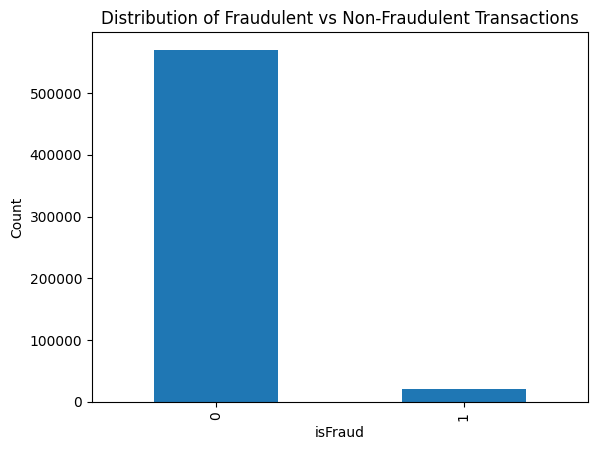

In [4]:
# Missing value percentages per column
missing_percent = (train.isnull().sum() / len(train)) * 100
missing_percent = missing_percent.sort_values(ascending=False)
print("Missing percentages per column:")
print(missing_percent[missing_percent > 0])

# Distribution of the target variable 'isFraud'
train['isFraud'].value_counts().plot(kind='bar')
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

In [5]:
null_cols = [col for col in train.columns if train[col].isna().sum() > 0.9 * len(train)]
null_cols

['dist2',
 'D7',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

In [6]:
missing_df = train.copy(deep=True)
for col in null_cols:
    missing_df["m_flag_"+col] = np.where(missing_df[col].isnull(), 1, 0)
    correlation = missing_df[["m_flag_"+col, 'isFraud']].corr()
    print(correlation)


              m_flag_dist2   isFraud
m_flag_dist2      1.000000 -0.091096
isFraud          -0.091096  1.000000
           m_flag_D7   isFraud
m_flag_D7   1.000000 -0.164478
isFraud    -0.164478  1.000000
              m_flag_id_07   isFraud
m_flag_id_07      1.000000 -0.024333
isFraud          -0.024333  1.000000
              m_flag_id_08   isFraud
m_flag_id_08      1.000000 -0.024333
isFraud          -0.024333  1.000000
              m_flag_id_18   isFraud
m_flag_id_18      1.000000 -0.074815
isFraud          -0.074815  1.000000
              m_flag_id_21  isFraud
m_flag_id_21       1.00000 -0.02431
isFraud           -0.02431  1.00000
              m_flag_id_22   isFraud
m_flag_id_22      1.000000 -0.024252
isFraud          -0.024252  1.000000
              m_flag_id_23   isFraud
m_flag_id_23      1.000000 -0.024252
isFraud          -0.024252  1.000000
              m_flag_id_24   isFraud
m_flag_id_24      1.000000 -0.024345
isFraud          -0.024345  1.000000
              m_flag_i

In [7]:
categorical_features = train.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    print(col, len(set(train[col])), set(train[col]))

ProductCD 5 {'W', 'R', 'C', 'S', 'H'}
card4 5 {'mastercard', 'visa', 'american express', 'discover', nan}
card6 5 {'credit', 'debit', 'charge card', 'debit or credit', nan}
P_emaildomain 60 {'centurylink.net', 'earthlink.net', 'frontiernet.net', 'outlook.com', 'sbcglobal.net', 'netzero.net', 'juno.com', 'icloud.com', 'cableone.net', 'live.com', 'netzero.com', 'gmail', 'yahoo.fr', 'ptd.net', 'gmail.com', 'hotmail.co.uk', 'anonymous.com', 'yahoo.es', nan, 'yahoo.com.mx', 'windstream.net', 'charter.net', 'rocketmail.com', 'cfl.rr.com', 'web.de', 'hotmail.de', 'mail.com', 'hotmail.es', 'aim.com', 'mac.com', 'servicios-ta.com', 'protonmail.com', 'gmx.de', 'verizon.net', 'frontier.com', 'bellsouth.net', 'optonline.net', 'yahoo.co.uk', 'yahoo.com', 'live.com.mx', 'cox.net', 'ymail.com', 'suddenlink.net', 'yahoo.co.jp', 'me.com', 'live.fr', 'hotmail.fr', 'yahoo.de', 'q.com', 'hotmail.com', 'prodigy.net.mx', 'msn.com', 'comcast.net', 'att.net', 'aol.com', 'embarqmail.com', 'outlook.es', 'twc.co

### Find truly categorical values

Screen resolution values are true numerical values, while all other features are categorical in nature

In [8]:
train[['Screen_Width', 'Screen_Height']] = train['id_33'].str.split('x', expand=True).astype(float)
train = train.drop(columns=['id_33'])

In [9]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns

# Identify candidate categorical features based on unique value counts
candidate_categorical = {}
# Set a threshold for maximum unique values
unique_threshold = 20

# Iterate over numeric columns to check unique value counts
for col in train.select_dtypes(include=['int64', 'float64']).columns:
    unique_vals = train[col].nunique()
    if unique_vals < unique_threshold and col != "isFraud":
        candidate_categorical[col] = unique_vals

# Print candidate categorical features
print("Candidate categorical features (numeric columns with few unique values):")
for col, count in candidate_categorical.items():
    print(f"{col}: {count} unique values")

Candidate categorical features (numeric columns with few unique values):
V1: 2 unique values
V2: 9 unique values
V3: 10 unique values
V4: 7 unique values
V5: 7 unique values
V6: 10 unique values
V7: 10 unique values
V8: 9 unique values
V9: 9 unique values
V10: 5 unique values
V11: 6 unique values
V12: 4 unique values
V13: 7 unique values
V14: 2 unique values
V15: 8 unique values
V16: 15 unique values
V17: 16 unique values
V18: 16 unique values
V19: 8 unique values
V20: 15 unique values
V21: 6 unique values
V22: 9 unique values
V23: 14 unique values
V24: 14 unique values
V25: 7 unique values
V26: 13 unique values
V27: 4 unique values
V28: 4 unique values
V29: 6 unique values
V30: 8 unique values
V31: 8 unique values
V32: 15 unique values
V33: 7 unique values
V34: 13 unique values
V35: 4 unique values
V36: 6 unique values
V39: 16 unique values
V40: 18 unique values
V41: 2 unique values
V42: 9 unique values
V43: 9 unique values
V46: 7 unique values
V47: 9 unique values
V48: 6 unique value

### Imputing nulls

Not using standard imputation:
1. Placed zero values as indicator for missing values where feature values no zero values anywhere else
2. Added 'missing' instead of null for categorical values to keep all the columns

In [10]:
# Identify numeric and categorical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = list(set(cat_cols).union(set(candidate_categorical.keys())))
num_cols = [col for col in num_cols if col not in cat_cols and col not in ("TransactionID", "isFraud")]

# Imputation for numeric columns using zeros as indicator
num_imputer = SimpleImputer(strategy='constant', fill_value=0)
train[num_cols] = num_imputer.fit_transform(train[num_cols])

# Imputation for categorical columns using a constant value
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

# Confirm that no missing values remain (or check overall missing count)
print("Total missing values after imputation:", train.isnull().sum().sum())

Total missing values after imputation: 0


### Data encoding

In [11]:
X = train.drop(columns=["isFraud", "TransactionID"])
y = train['isFraud']

### Encoding categorical features

Splitting train and test asap

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Using novel thing: WOE encoder to compensate for an enormous dimentionality for SVC

In [13]:
encoder_high = ce.WOEEncoder(cols=cat_cols)
X_train_encoded_cat = encoder_high.fit_transform(X_train[cat_cols], y_train)
X_test_encoded_cat = encoder_high.transform(X_test[cat_cols])

KeyboardInterrupt: 

### Data normalization

Scale data to remove any disrepancies in SVC

In [15]:
scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train[num_cols])
X_test_scaled_num = scaler.transform(X_test[num_cols])

In [16]:
X_train_scaled = pd.DataFrame(np.hstack([X_train_encoded_cat.values, X_train_scaled_num]), columns=cat_cols + num_cols)
X_test_scaled = pd.DataFrame(np.hstack([X_test_encoded_cat.values, X_test_scaled_num]), columns=cat_cols + num_cols)

In [17]:
print("Encoded training set shape:", X_train_scaled.shape)
print("Encoded test set shape:", X_test_scaled.shape)

Encoded training set shape: (472432, 433)
Encoded test set shape: (118108, 433)


In [18]:
X_train_scaled.head()

,V108,V29,V35,V19,V47,V325,V119,V66,V14,M3,V98,V61,M4,V42,id_29,V84,V40,V53,V83,V113,V89,M7,V63,V251,P_emaildomain,V120,V49,V111,V33,id_36,V62,V250,V90,V118,V109,M5,card6,V17,V300,M8,M9,id_12,id_18,V60,V75,V301,V28,V241,V123,V302,V4,V327,V51,V117,V2,V71,id_34,V153,V73,V124,V43,V72,V85,V305,V31,ProductCD,V7,V69,M6,V10,V94,id_15,V15,V9,V25,V125,DeviceType,V20,V116,V46,M1,V141,V286,V88,V55,V82,V122,V30,V110,V70,V26,V58,V195,V328,id_23,V68,V57,V114,V289,V18,id_28,id_30,V8,V297,V91,V11,V1,id_24,DeviceInfo,V64,V247,V21,V67,id_27,V197,V115,V142,V48,V39,V92,V6,V174,V240,V104,id_35,id_38,V54,id_31,id_04,R_emaildomain,V284,V65,card4,V24,V107,V50,id_37,V16,V5,V175,V34,V74,V304,V12,V173,V23,V194,V13,M2,V112,V27,V3,V288,V22,V184,V59,V36,V76,V41,V79,V223,V52,V32,V260,id_16,id_32,V154,V93,V121,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V37,V38,V44,V45,V56,V77,V78,V80,V81,V86,V87,V95,V96,V97,V99,V100,V101,V102,V103,V105,V106,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V176,V177,V178,V179,V180,V181,V182,V183,V185,V186,V187,V188,V189,V190,V191,V192,V193,V196,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V242,V243,V244,V245,V246,V248,V249,V252,V253,V254,V255,V256,V257,V258,V259,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V285,V287,V290,V291,V292,V293,V294,V295,V296,V298,V299,V303,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V326,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_21,id_22,id_25,id_26,Screen_Width,Screen_Height
0,-0.033578,0.383795,0.028950,0.383795,0.028950,0.237782,-0.010113,0.531234,0.383795,0.423702,-0.038494,0.531234,-0.653040,0.028950,1.161001,0.325713,0.028950,0.531234,0.325713,-0.036001,0.325713,0.275378,0.531234,0.610189,-0.395075,-0.004153,0.028950,-0.035588,0.383795,0.894744,0.531234,0.644286,0.325713,-0.009934,-0.033529,0.066966,0.682454,0.383795,-0.026793,0.275416,0.275416,0.893194,-0.121683,0.531234,0.325713,-0.036066,0.383795,0.843918,-0.085018,0.827407,0.410700,0.216208,0.028950,-0.009943,0.410700,0.531234,0.106197,0.069703,0.531234,-0.073621,0.02895,0.531234,0.325713,-0.000099,0.383795,0.090415,0.410700,0.531234,0.737784,0.41070,0.325713,1.165839,0.383795,0.410700,0.383795,-0.086159,0.652664,0.383795,-0.046097,0.028950,0.423702,0.174927,-0.005473,0.325713,0.531234,0.325713,-0.004764,0.383795,-0.034195,0.531234,0.383795,0.531234,0.531945,0.190160,-0.012757,0.531234,0.531234,-0.043011,-0.080630,0.383795,1.142724,-0.063873,0.410700,-0.017537,0.325713,0.41070,0.410700,-0.01215,-1.080841,0.531234,0.702588,0.383795,0.531234,-0.012757,0.553973,-0.045227,0.173348,0.028950,0.02895,0.325713,0.410700,0.829283,0.843236,-0.024835,0.243019,0.542538,0.531234,-0.612598,1.174202,-0.169704,-0.060493,0.531234,-0.142730,0.383795,-0.000195,0.02895,0.915791,0.383795,0.410700,0.827610,0.383795,0.531234,0.802900,0.383795,0.872048,0.383795,0.553973,0.383795,0.423702,-0.03759,0.383795,0.410700,-0.077195,0.383795,0.719326,0.531234,0.028950,0.325713,0.02895,0.325713,0.836027,0.028950,0.383795,0.708125,1.187974,-0.043298,0.031686,0.325713,-0.004744,-1.378728,-0.145302,-0.759998,0.257853,-0.203484,-1.078432,0.042876,0.360192,-0.196545,-0.094803,-0.098434,-0.092693,-0.039137,-0.030306,-0.215803,-0.113225,-0.046189,-0.032914,-0.268532,-0.033820,-0.098328,-0.047102,-0.236331,-0.147581,3.269944,3.383160,-0.323817,-0.576067,-0.309651,-0.155767,-0.099152,6.159508,2.726051,-0.616023,

### Save data

In [19]:
X_train_scaled.to_csv("data/preprocessed_train.csv", index=False)
X_test_scaled.to_csv("data/preprocessed_test.csv", index=False)

y_train.to_csv("data/y_train.csv", index=False)
y_test.to_csv("data/y_test.csv", index=False)

### Baseline catboost

Download processed data

In [ ]:
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_test_scaled = pd.read_csv("data/preprocessed_test.csv")
y_train = pd.read_csv("data/y_train.csv")
y_test = pd.read_csv("data/y_test.csv")

Accounting for severe class imbalance

In [4]:
# Convert y_train to numpy array (since it's read as DataFrame)
y_train_array = y_train['isFraud'].values

# Get unique classes and compute weights
unique_classes = np.unique(y_train_array)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=y_train_array
)

# Create dictionary of class weights
class_weights_dict = dict(zip(unique_classes, class_weights))
class_weights_dict = {int(k): float(v) for k, v in class_weights_dict.items()}

PCA

In [20]:
pca = PCA(n_components=100)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

Independent Component Analysis (ICA)

In [23]:
ica = FastICA(n_components=100, random_state=42)
X_train_scaled = ica.fit_transform(X_train_scaled)
X_test_scaled = ica.transform(X_test_scaled)

Truncated SVD

In [ ]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_scaled = svd.fit_transform(X_train_scaled)
X_test_scaled = svd.transform(X_test_scaled)

Train baseline model

In [26]:
from catboost import CatBoostClassifier

y_train_flat = y_train.values.ravel()
y_test_flat = y_test.values.ravel()

model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights_dict,
    random_seed=42,
    verbose=100
)
model_cat.fit(X_train_scaled, y_train_flat)
y_pred_cat = model_cat.predict(X_test_scaled)
print("CatBoost Training Accuracy:", accuracy_score(y_test_flat, y_pred_cat))

0:	learn: 0.6515508	total: 133ms	remaining: 1m 6s
100:	learn: 0.3743155	total: 13.2s	remaining: 52s
200:	learn: 0.3282363	total: 26.8s	remaining: 39.9s
300:	learn: 0.2981647	total: 40.3s	remaining: 26.6s
400:	learn: 0.2745897	total: 54.2s	remaining: 13.4s
499:	learn: 0.2570046	total: 1m 7s	remaining: 0us
CatBoost Training Accuracy: 0.9161614793240085


#### With all features:
0:	learn: 0.6515508	total: 127ms	remaining: 1m 3s 

100:	learn: 0.3743155	total: 13.5s	remaining: 53.4s

200:	learn: 0.3282363	total: 26.9s	remaining: 40s

300:	learn: 0.2981647	total: 40s	remaining: 26.5s

400:	learn: 0.2745897	total: 53.3s	remaining: 13.2s

499:	learn: 0.2570046	total: 1m 6s	remaining: 0us

CatBoost Training Accuracy: **0.9161614793240085**

#### With PCA:
0:	learn: 0.6585685	total: 31.1ms	remaining: 15.5s

100:	learn: 0.4369775	total: 2.81s	remaining: 11.1s

200:	learn: 0.3974325	total: 5.63s	remaining: 8.38s

300:	learn: 0.3670191	total: 8.58s	remaining: 5.67s

400:	learn: 0.3430025	total: 11.6s	remaining: 2.86s

499:	learn: 0.3227418	total: 14.7s	remaining: 0us

CatBoost Training Accuracy: **0.8818962305686321**

#### With ISA:
0:	learn: 0.6616616	total: 32.2ms	remaining: 16.1s

100:	learn: 0.4328070	total: 3.35s	remaining: 13.2s

200:	learn: 0.3877602	total: 6.7s	remaining: 9.97s

300:	learn: 0.3543754	total: 10.1s	remaining: 6.69s

400:	learn: 0.3284518	total: 13.5s	remaining: 3.33s

499:	learn: 0.3067547	total: 16.8s	remaining: 0us

CatBoost Training Accuracy: **0.8889490974362448**

#### With SVD:
0:	learn: 0.6515508	total: 133ms	remaining: 1m 6s

100:	learn: 0.3743155	total: 13.2s	remaining: 52s

200:	learn: 0.3282363	total: 26.8s	remaining: 39.9s

300:	learn: 0.2981647	total: 40.3s	remaining: 26.6s

400:	learn: 0.2745897	total: 54.2s	remaining: 13.4s

499:	learn: 0.2570046	total: 1m 7s	remaining: 0us

CatBoost Training Accuracy: **0.9161614793240085**

### GA for input features subset selection

In [29]:
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_test_scaled = pd.read_csv("data/preprocessed_test.csv")
y_train = pd.read_csv("data/y_train.csv")
y_test = pd.read_csv("data/y_test.csv")

In [31]:
def run_genetic_algorithm(X_data, y_data, population_size=20, n_generations=10, subset_size=100):
    n_features = X_data.shape[1]
    
    # Initialize population - each individual is a sorted list of feature indices
    population = []
    for _ in range(population_size):
        subset = random.sample(range(n_features), subset_size)
        subset.sort()
        population.append(subset)
    
    def fitness(individual):
        # Train SVC with this subset and return average cross-validation accuracy
        X_subset = X_data.iloc[:, individual]
        model = CatBoostClassifier(
            iterations=500,
            learning_rate=0.1,
            depth=6,
            class_weights=class_weights_dict,
            random_seed=42,
            verbose=100
        )
        scores = cross_val_score(model, X_subset, y_data, cv=3, scoring='accuracy')
        return scores.mean()
    
    # Creates a child by merging features from both parents and selecting a random subset
    def crossover(p1, p2, subset_size):
        combined = list(set(p1) | set(p2))  # Union of features
        if len(combined) > subset_size:
            child = sorted(random.sample(combined, subset_size))  # Ensure correct size
        else:
            child = sorted(combined)  # Keep all if below subset_size
        return child

    # Mutation replaces a random index in child if random.threshold is met
    def mutation(individual, n_features, subset_size):
        if random.random() < 0.1:  # 10% chance of mutation
            i = random.randrange(subset_size)
            available_features = set(range(n_features)) - set(individual)  # Exclude existing features
            if available_features:  
                new_feature = random.choice(list(available_features))
                individual[i] = new_feature
                individual.sort()
        return individual


    for i in range(n_generations):
        print("Generation", i)
        # Evaluate fitness of population
        scored_population = [(fitness(ind), ind) for ind in population]
        scored_population.sort(key=lambda x: x[0], reverse=True)
        
        # Selection: truncation selection (pick top half as survivors)
        survivors = scored_population[: population_size // 2]
        
        # Then randomly select two parents (p1 & p2) from survivors for crossover + mutation
        new_pop = [s[1] for s in survivors]
        while len(new_pop) < population_size:
            p1 = random.choice(survivors)[1]
            p2 = random.choice(survivors)[1]
            child = crossover(p1, p2, subset_size)
            child = mutation(child, n_features, subset_size)
            
            child = list(set(child))  # remove duplicates if any
            while len(child) < subset_size:  # if duplicates reduced size
                child.append(random.randrange(n_features))
            child.sort()
            new_pop.append(child)
        population = new_pop
        print("Current best:", max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1])
    
    best = max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1]
    return best

best_features = run_genetic_algorithm(X_train_scaled, y_train)
X_train_ga = X_train.iloc[:, best_features]
X_test_ga = X_test.iloc[:, best_features]
model = CatBoostClassifier(
            iterations=500,
            learning_rate=0.1,
            depth=6,
            class_weights=class_weights_dict,
            random_seed=42,
            verbose=100
        )
model.fit(X_train_ga, y_train)
y_pred = model.predict(X_test)
print("Model accuracy with selected features:", accuracy_score(y_test, y_pred))

0:	learn: 0.6538240	total: 29.6ms	remaining: 14.8s
100:	learn: 0.4322213	total: 3.11s	remaining: 12.3s
200:	learn: 0.3994994	total: 6.01s	remaining: 8.94s
300:	learn: 0.3762292	total: 8.92s	remaining: 5.9s
400:	learn: 0.3583937	total: 11.9s	remaining: 2.93s
499:	learn: 0.3427946	total: 14.7s	remaining: 0us
0:	learn: 0.6538828	total: 29.3ms	remaining: 14.6s
100:	learn: 0.4308126	total: 2.86s	remaining: 11.3s
200:	learn: 0.3953213	total: 5.79s	remaining: 8.61s
300:	learn: 0.3716386	total: 8.75s	remaining: 5.79s
400:	learn: 0.3534609	total: 11.8s	remaining: 2.9s
499:	learn: 0.3379624	total: 14.6s	remaining: 0us
0:	learn: 0.6496181	total: 29.9ms	remaining: 14.9s
100:	learn: 0.4284727	total: 2.94s	remaining: 11.6s
200:	learn: 0.3952698	total: 5.88s	remaining: 8.74s
300:	learn: 0.3706273	total: 8.95s	remaining: 5.92s
400:	learn: 0.3538911	total: 12s	remaining: 2.95s
499:	learn: 0.3392302	total: 15s	remaining: 0us
0:	learn: 0.6552081	total: 27ms	remaining: 13.5s
100:	learn: 0.4343616	total: 2

KeyboardInterrupt: 

### PSO and ACO for catboost hyperparameter tuning

In [ ]:
def run_pso_for_catboost_hyperparams(X_data, y_data, n_particles=10, n_iterations=5):
    # Define parameter search spaces
    param_bounds = {
        'learning_rate': (0.01, 0.3),
        'depth': (3, 10),
        'l2_leaf_reg': (1.0, 10.0),
        'iterations': (100, 1000)
    }
    
    # Initialize particles
    positions = []
    for _ in range(n_particles):
        pos = {
            'learning_rate': random.uniform(*param_bounds['learning_rate']),
            'depth': int(random.uniform(*param_bounds['depth'])),
            'l2_leaf_reg': random.uniform(*param_bounds['l2_leaf_reg']),
            'iterations': int(random.uniform(*param_bounds['iterations']))
        }
        positions.append(pos)
    
    velocities = [{k: 0.0 for k in param_bounds.keys()} for _ in range(n_particles)]
    
    # Personal and global bests
    pbest_positions = positions[:]
    pbest_scores = [0.0] * n_particles
    gbest_position = None
    gbest_score = 0.0
    
    def fitness(params):
        model = CatBoostClassifier(
            **params,
            class_weights=class_weights_dict,
            random_seed=42,
            verbose=False
        )
        scores = cross_val_score(model, X_data, y_data, cv=3, scoring='accuracy')
        return scores.mean()
    
    # Evaluate initial fitness
    for i in range(n_particles):
        score = fitness(positions[i])
        pbest_scores[i] = score
        if score > gbest_score:
            gbest_score = score
            gbest_position = positions[i].copy()
    
    # Main PSO loop
    w, c1, c2 = 0.5, 1.0, 1.0
    for _ in range(n_iterations):
        for i in range(n_particles):
            r1, r2 = random.random(), random.random()
            
            # Update velocities and positions for each parameter
            for param in param_bounds.keys():
                velocities[i][param] = (
                    w * velocities[i][param] +
                    c1 * r1 * (pbest_positions[i][param] - positions[i][param]) +
                    c2 * r2 * (gbest_position[param] - positions[i][param])
                )
                
                positions[i][param] += velocities[i][param]
                
                # Ensure bounds and proper types
                if param == 'depth' or param == 'iterations':
                    positions[i][param] = int(max(param_bounds[param][0],
                                               min(param_bounds[param][1],
                                                   positions[i][param])))
                else:
                    positions[i][param] = max(param_bounds[param][0],
                                           min(param_bounds[param][1],
                                               positions[i][param]))
            
            # Evaluate fitness
            score = fitness(positions[i])
            if score > pbest_scores[i]:
                pbest_scores[i] = score
                pbest_positions[i] = positions[i].copy()
                if score > gbest_score:
                    gbest_score = score
                    gbest_position = positions[i].copy()
    
    return gbest_position

In [ ]:
def run_aco_for_catboost_hyperparams(X_data, y_data, n_ants=10, n_iterations=5):
    # Define parameter spaces and bins
    n_bins = 10
    param_bounds = {
        'learning_rate': (0.01, 0.3),
        'depth': (3, 10),
        'l2_leaf_reg': (1.0, 10.0),
        'iterations': (100, 1000)
    }
    
    # Initialize pheromone levels for each parameter
    pheromones = {param: [1.0] * n_bins for param in param_bounds.keys()}
    
    def bin_to_value(bin_index, param):
        min_val, max_val = param_bounds[param]
        step_size = (max_val - min_val) / n_bins
        val = min_val + bin_index * step_size + (step_size / 2)
        return int(val) if param in ['depth', 'iterations'] else val
    
    def fitness(params):
        model = CatBoostClassifier(
            **params,
            class_weights=class_weights_dict,
            random_seed=42,
            verbose=False
        )
        scores = cross_val_score(model, X_data, y_data, cv=3, scoring='accuracy')
        return scores.mean()
    
    best_score = 0.0
    best_params = None
    
    for _ in range(n_iterations):
        solutions = []
        
        # Generate solutions for each ant
        for _ in range(n_ants):
            current_params = {}
            for param in param_bounds.keys():
                bin_idx = random.choices(range(n_bins), 
                                      weights=pheromones[param], 
                                      k=1)[0]
                current_params[param] = bin_to_value(bin_idx, param)
            
            score = fitness(current_params)
            solutions.append((current_params, score))
        
        # Evaporate pheromones
        for param in pheromones:
            for i in range(n_bins):
                pheromones[param][i] *= 0.9
        
        # Update pheromones based on solutions
        for params, score in solutions:
            if score > best_score:
                best_score = score
                best_params = params.copy()
            
            # Deposit pheromones
            for param, value in params.items():
                bin_idx = int((value - param_bounds[param][0]) / 
                            (param_bounds[param][1] - param_bounds[param][0]) * n_bins)
                bin_idx = min(bin_idx, n_bins - 1)
                pheromones[param][bin_idx] += score
    
    return best_params

Example usage

In [ ]:
best_params_pso = run_pso_for_catboost_hyperparams(X_train_scaled, y_train_flat)
model_cat_pso = CatBoostClassifier(**best_params_pso, class_weights=class_weights_dict, random_seed=42)
model_cat_pso.fit(X_train_scaled, y_train_flat)
y_pred_cat_pso = model_cat_pso.predict(X_test_scaled)
print("PSO-tuned CatBoost Accuracy:", accuracy_score(y_test_flat, y_pred_cat_pso))

best_params_aco = run_aco_for_catboost_hyperparams(X_train_scaled, y_train_flat)
model_cat_aco = CatBoostClassifier(**best_params_aco, class_weights=class_weights_dict, random_seed=42)
model_cat_aco.fit(X_train_scaled, y_train_flat)
y_pred_cat_aco = model_cat_aco.predict(X_test_scaled)
print("ACO-tuned CatBoost Accuracy:", accuracy_score(y_test_flat, y_pred_cat_aco))